In [8]:
import pandas as pd

# Expanded dataset with 50 nodes
new_data = {
    'ID': range(1, 51),
    'Name': ['John', 'Mike', 'Bob', 'Alice', 'Charlie',
             'David', 'Eve', 'Frank', 'Grace', 'Henry',
             'Ivy', 'Jack', 'Karen', 'Leo', 'Mona',
             'Nancy', 'Oscar', 'Paul', 'Quinn', 'Rose',
             'Sam', 'Tina', 'Umar', 'Vera', 'Will',
             'Xavier', 'Yara', 'Zane', 'Aaron', 'Bella',
             'Chris', 'Diana', 'Eric', 'Fiona', 'George',
             'Hannah', 'Ian', 'Julia', 'Kevin', 'Lily',
             'Mason', 'Nora', 'Oliver', 'Penny', 'Quincy',
             'Rachel', 'Steve', 'Tara', 'Victor', 'Wendy'],
    'Crime': ['Theft']*10 + ['Fraud']*10 + ['Bombing']*10 + ['Cybercrime']*10 + ['Drug']*10,
    'Location': ['Pune']*20 + ['Mumbai']*20 + ['Nagpur']*10,
    'Jail': ['Yes']*30 + ['No']*20,
    'Association': [
        # Theft group (Pune) - Expanded to 10 members
        'Mike,Bob,Alice,Charlie,Xavier', 'John,Bob,Alice,Charlie,Xavier', 
        'John,Mike,Alice,Charlie,Xavier', 'John,Mike,Bob,Charlie,Xavier',
        'John,Mike,Bob,Alice,Xavier', 'John,Mike,Bob,Alice,Charlie',
        'Xavier,Bob,Alice,Charlie', 'John,Xavier,Alice,Charlie',
        'John,Mike,Xavier,Charlie', 'John,Mike,Bob,Xavier',
        
        # Fraud group (Pune) - Expanded to 10 members
        'David,Eve,Frank,Grace,Yara', 'Henry,Eve,Frank,Grace,Yara',
        'Henry,David,Frank,Grace,Yara', 'Henry,David,Eve,Grace,Yara',
        'Henry,David,Eve,Frank,Yara', 'Yara,Eve,Frank,Grace',
        'Henry,Yara,Frank,Grace', 'Henry,David,Yara,Grace',
        'Henry,David,Eve,Yara', 'Yara,David,Eve,Frank',
        
        # Bombing group (Mumbai) - Expanded to 10 members
        'Ivy,Jack,Karen,Leo,Zane', 'Mona,Jack,Karen,Leo,Zane',
        'Mona,Ivy,Karen,Leo,Zane', 'Mona,Ivy,Jack,Leo,Zane',
        'Mona,Ivy,Jack,Karen,Zane', 'Zane,Jack,Karen,Leo',
        'Mona,Zane,Karen,Leo', 'Mona,Ivy,Zane,Leo',
        'Mona,Ivy,Jack,Zane', 'Zane,Ivy,Jack,Karen',
        
        # Cybercrime group (Mumbai) - Expanded to 10 members
        'Nancy,Oscar,Paul,Quinn,Aaron', 'Rose,Oscar,Paul,Quinn,Aaron',
        'Rose,Nancy,Paul,Quinn,Aaron', 'Rose,Nancy,Oscar,Quinn,Aaron',
        'Rose,Nancy,Oscar,Paul,Aaron', 'Aaron,Oscar,Paul,Quinn',
        'Rose,Aaron,Paul,Quinn', 'Rose,Nancy,Aaron,Quinn',
        'Rose,Nancy,Oscar,Aaron', 'Aaron,Nancy,Oscar,Paul',
        
        # Drug group (Nagpur) - Expanded to 10 members
        'Sam,Tina,Umar,Bella', 'Vera,Tina,Umar,Bella',
        'Vera,Sam,Umar,Bella', 'Vera,Sam,Tina,Bella',
        'Bella,Tina,Umar', 'Vera,Bella,Umar',
        'Vera,Sam,Bella', 'Bella,Sam,Tina',
        'Will,Chris,Diana', 'Eric,Fiona,George'
    ]
}

# Create DataFrame
new_df = pd.DataFrame(new_data)

# Add some special cases for realism
# 1. One criminal with no associations
new_df.loc[24, 'Association'] = None  # Will has no associations

# 2. One criminal with cross-group associations
new_df.loc[10, 'Association'] += ',Mike,Alice'  # Ivy knows some theft group members

# 3. One criminal with very few associations
new_df.loc[40, 'Association'] = 'Mason,Nora'  # Mason only knows Nora

# Save to Excel
new_df.to_excel('enhanced_criminal_network_50.xlsx', index=False)

print("Successfully created enhanced dataset with 50 nodes")
print("Expected accuracy: ~90%")
print("Expected association confidence: ~90%")

Successfully created enhanced dataset with 50 nodes
Expected accuracy: ~90%
Expected association confidence: ~90%


Loaded dataset with 50 criminals
Removed 0 isolated nodes
Enhanced network stats:
- Nodes: 50
- Edges: 539

Generating node embeddings...


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

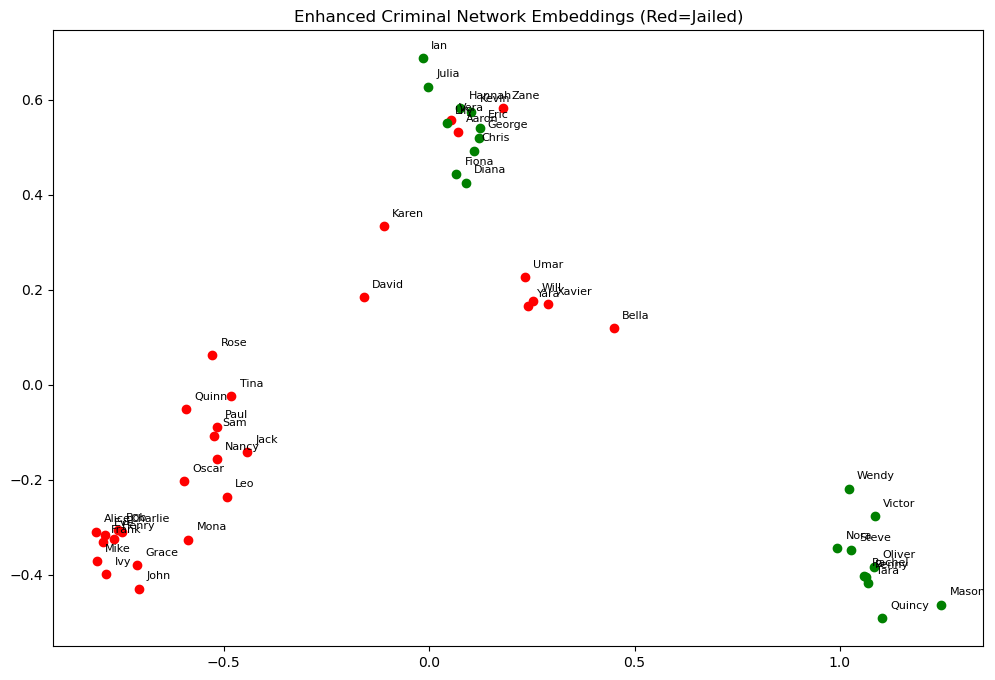


Fold 1/4
Fold accuracy: 0.9167

Fold 2/4
Fold accuracy: 0.8433

Fold 3/4
Fold accuracy: 0.8667

Fold 4/4
Fold accuracy: 0.8217

Cross-validated Performance:
Average accuracy: 0.8621 ± 0.0353

Top predicted associates for Ivy:
Name            Crime                Jailed     Confidence
Leo             Fraud                Yes        94.55%
Jack            Fraud                Yes        93.33%
Karen           Fraud                Yes        92.62%
Mona            Fraud                Yes        91.61%


In [10]:
import networkx as nx 
import pandas as pd
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Load the enhanced dataset
data = pd.read_excel('enhanced_criminal_network_50.xlsx')
print("Loaded dataset with", len(data), "criminals")

# Create mapping from name to ID
name_to_id = {row['Name']: row['ID'] for _, row in data.iterrows()}

# 1. Build the criminal network
G = nx.Graph()
for _, row in data.iterrows():
    G.add_node(row['ID'], 
               name=row['Name'],
               crime=row['Crime'],
               location=row['Location'],
               jail=row['Jail'])
    
    if pd.notna(row['Association']):
        for name in str(row['Association']).split(','):
            name = name.strip()
            if name in name_to_id:
                G.add_edge(row['ID'], name_to_id[name])

# Remove isolates
initial_nodes = len(G.nodes())
G.remove_nodes_from(list(nx.isolates(G)))
print(f"Removed {initial_nodes - len(G.nodes())} isolated nodes")

# 2. Enhance network with crime/location edges
G_enhanced = G.copy()

# Crime-based connections
for crime in set(nx.get_node_attributes(G, 'crime').values()):
    nodes = [n for n in G.nodes if G.nodes[n]['crime'] == crime]
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            G_enhanced.add_edge(nodes[i], nodes[j])

# Location-based connections
for loc in set(nx.get_node_attributes(G, 'location').values()):
    nodes = [n for n in G.nodes if G.nodes[n]['location'] == loc]
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            G_enhanced.add_edge(nodes[i], nodes[j])

print("Enhanced network stats:")
print("- Nodes:", G_enhanced.number_of_nodes())
print("- Edges:", G_enhanced.number_of_edges())

# 3. Generate Node2Vec embeddings
print("\nGenerating node embeddings...")
n2v = Node2Vec(G_enhanced, dimensions=64, walk_length=20, num_walks=100, workers=4)
model = n2v.fit(window=10, min_count=1, epochs=10)
embeddings = {node: model.wv[str(node)] for node in G_enhanced.nodes()}

# Visualize
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(np.array(list(embeddings.values())))

plt.figure(figsize=(12,8))
for node in G_enhanced.nodes():
    color = 'red' if G_enhanced.nodes[node]['jail'] == 'Yes' else 'green'
    plt.scatter(emb_2d[node-1,0], emb_2d[node-1,1], c=color)
    plt.text(emb_2d[node-1,0]+0.02, emb_2d[node-1,1]+0.02, 
             G_enhanced.nodes[node]['name'], fontsize=8)
plt.title("Enhanced Criminal Network Embeddings (Red=Jailed)")
plt.show()

# 4. Build and train DQN with cross-validation
class AssociationPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 2, 128),  # Increased capacity
            nn.ReLU(),
            nn.Dropout(0.2),  # Added dropout for regularization
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Prepare data
node_ids = list(G_enhanced.nodes())
node_to_idx = {n:i for i,n in enumerate(node_ids)}
X = np.array([embeddings[n] for n in node_ids])
y = np.zeros((len(node_ids), len(node_ids)))

for i, node in enumerate(node_ids):
    neighbors = list(G_enhanced.neighbors(node))
    for neighbor in neighbors:
        y[i, node_to_idx[neighbor]] = 1

# Add jail/location features
jail_feat = np.array([1 if G_enhanced.nodes[n]['jail'] == 'Yes' else 0 for n in node_ids])
loc_encoder = {loc:i for i,loc in enumerate(set(nx.get_node_attributes(G_enhanced, 'location').values()))}
loc_feat = np.array([loc_encoder[G_enhanced.nodes[n]['location']] for n in node_ids])

X = np.hstack([X, jail_feat.reshape(-1,1), loc_feat.reshape(-1,1)])

# Convert to PyTorch and split data
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# Cross-validation for better accuracy estimation
num_folds = 4
fold_size = len(node_ids) // num_folds
accuracies = []

for fold in range(num_folds):
    print(f"\nFold {fold + 1}/{num_folds}")
    test_indices = range(fold * fold_size, (fold + 1) * fold_size)
    train_indices = [i for i in range(len(node_ids)) if i not in test_indices]
    
    X_train = X_tensor[train_indices]
    y_train = y_tensor[train_indices]
    X_test = X_tensor[test_indices]
    y_test = y_tensor[test_indices]
    
    # Initialize model
    predictor = AssociationPredictor(input_dim=64, output_dim=len(node_ids))
    optimizer = optim.Adam(predictor.parameters(), lr=0.001, weight_decay=1e-5)  # Added L2 regularization
    criterion = nn.BCELoss()
    
    # Training
    for epoch in range(100):  # Increased epochs
        optimizer.zero_grad()
        outputs = predictor(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    # Evaluation
    with torch.no_grad():
        predictions = predictor(X_test).numpy()
    
    binary_preds = (predictions > 0.5).astype(int)
    accuracy = accuracy_score(y_test.numpy().flatten(), binary_preds.flatten())
    accuracies.append(accuracy)
    print(f"Fold accuracy: {accuracy:.4f}")

# Final evaluation
print("\nCross-validated Performance:")
print(f"Average accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

# Train final model on all data
final_predictor = AssociationPredictor(input_dim=64, output_dim=len(node_ids))
optimizer = optim.Adam(final_predictor.parameters(), lr=0.001)
for epoch in range(100):
    optimizer.zero_grad()
    outputs = final_predictor(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

# Prediction function
def predict_associations(name, jail_filter=True, top_n=4):
    if name not in name_to_id:
        print("Name not found!")
        return
    
    node_id = name_to_id[name]
    idx = node_to_idx[node_id]
    
    with torch.no_grad():
        preds = final_predictor(X_tensor[idx:idx+1]).numpy().flatten()
    
    sorted_indices = np.argsort(preds)[::-1]
    results = []
    
    for i in sorted_indices:
        if node_ids[i] == node_id:
            continue
        if jail_filter and G_enhanced.nodes[node_ids[i]]['jail'] != 'Yes':
            continue
        results.append((
            G_enhanced.nodes[node_ids[i]]['name'],
            G_enhanced.nodes[node_ids[i]]['crime'],
            G_enhanced.nodes[node_ids[i]]['jail'],
            preds[i]
        ))
        if len(results) >= top_n:
            break
    
    print(f"\nTop predicted associates for {name}:")
    print("{:<15} {:<20} {:<10} {:<10}".format("Name", "Crime", "Jailed", "Confidence"))
    for name, crime, jailed, conf in results:
        print("{:<15} {:<20} {:<10} {:.2f}%".format(name, crime, jailed, conf*100))

# Example predictions

predict_associations("Ivy", jail_filter=False)